In [1]:
# jakiś tekst z Internetu

text = open('pizza.txt').read().lower()

In [2]:
text[:300]

'pizza, the delectable and iconic dish that has transcended borders and captivated taste buds worldwide, is a testament to the extraordinary fusion of flavors, creativity, and cultural significance. originating from the sun-kissed lands of italy, pizza has evolved into an art form that unites people '

In [3]:
# tokenizacja tekstu

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')

tokens = tokenizer.tokenize(text)

In [4]:
# słowniki dla występujących słów

import numpy as np

unique_tokens = np.unique(tokens)
unique_token_index = {token:idx for idx, token in enumerate(unique_tokens)}
idx2word = {idx:token for idx, token in enumerate(unique_tokens)}

In [5]:
len(unique_token_index)

683

In [6]:
# parametry dla modelu

n_step = 3 # liczba zapamiętanych słów
batch_size = 10 # rozmiar batczu
n_class = len(unique_token_index) # 
n_hidden = 5 # liczba unikalnych słów w tekście

In [7]:
# przygotowanie tekstu do modelu. podział na features i targets

import torch

def preparing_text(tokens, step=n_step):
    input_batch = []
    target_batch = []
    eye = np.eye(n_class, dtype='float32')
    
    for i in range(len(tokens) - step):
        input = tokens[i:i + step]
        input = [unique_token_index[n] for n in input]
        input_batch.append(eye[input])

        target = tokens[i + step]
        target = unique_token_index[target]
        target_batch.append(eye[target])

    return torch.from_numpy(np.array(input_batch)), \
           torch.from_numpy(np.array(target_batch))

In [8]:
input_tensor, target_tensor = preparing_text(tokens=tokens)

In [9]:
input_tensor.shape

torch.Size([1711, 3, 683])

In [10]:
target_tensor.shape

torch.Size([1711, 683])

In [11]:
import torch.utils.data as Data

dataset = Data.TensorDataset(input_tensor, target_tensor)
loader = Data.DataLoader(dataset, batch_size, True)

In [12]:
# model GRU wypadł nieco lepiej niż RNN

import torch.nn as nn

class TextGRU(nn.Module):
    def __init__(self):
        super(TextGRU, self).__init__()
        # self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        self.rnn = nn.GRU(input_size=n_class, hidden_size=n_hidden)
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        out, hidden = self.rnn(X, hidden)
        out = out[-1]
        model = self.fc(out)
        return model

In [13]:
# parametry modelu

import torch.optim as optim

model = TextGRU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# trening modelu

loss_list = []
for epoch in range(1500):
    loss_avg = []
    for x, y in loader:
        hidden = torch.zeros(1, x.shape[0], n_hidden)
        pred = model(hidden, x)
        loss = criterion(pred, y)
        loss_avg.append(loss.item())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        loss_list.append(np.mean(loss_avg))
        print(np.mean(loss_avg))

6.550638750542042
3.4714042343372524
2.772850848214571
2.439685447011576
2.254794047322384
2.113273005845935
1.9764521006321492
1.876737269551255
1.7879124619066715
1.7125036166764276
1.6590240757132686
1.595887685237929
1.5442764059055683
1.505045902590419
1.4588336092095042


In [15]:
# przykład odgadnięcia słowa

predic_text = ['iconic', 'pizza', 'for', 'people']
hidden = torch.zeros(1, len(predic_text) - n_step, n_hidden)
predict = model(hidden, preparing_text(predic_text)[0]).data.max(1, keepdim=True)[1]
[idx2word[i.item()] for i in predict]

['advancements']

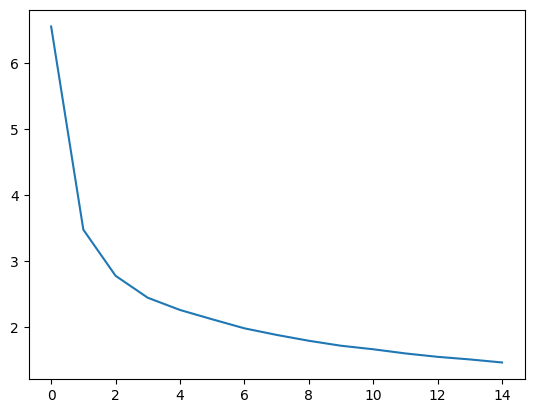

In [16]:
# wykres strat w zależności od epoki

import matplotlib.pyplot as plt
plt.plot(loss_list);

In [17]:
# proszę pana powiedzieć, co muszę robić dalej?